In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional
import pandas as pd
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
from senselab.audio.data_structures.audio import Audio
from senselab.audio.tasks.features_extraction.torchaudio import extract_spectrogram_from_audios
from senselab.tasks.preprocessing.preprocessing import resample_audios
from senselab.audio.tasks.plotting.plotting import plot_specgram
import IPython.display as Ipd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import chi2_contingency


### Audiorecordings(from lectures)

dict_keys(['speaker_embedding', 'specgram', 'melfilterbank', 'mfcc', 'sample_rate', 'opensmile'])


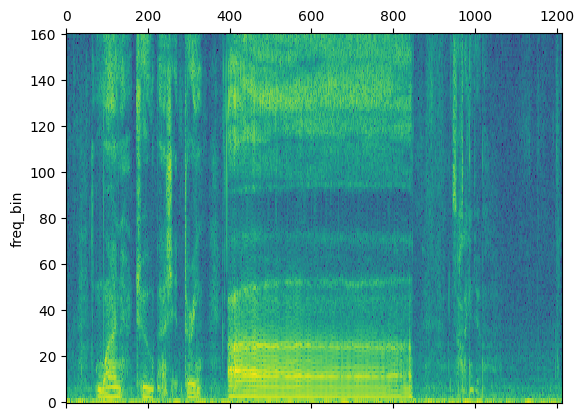

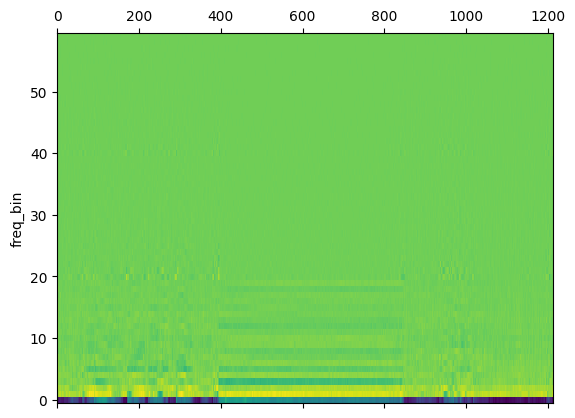

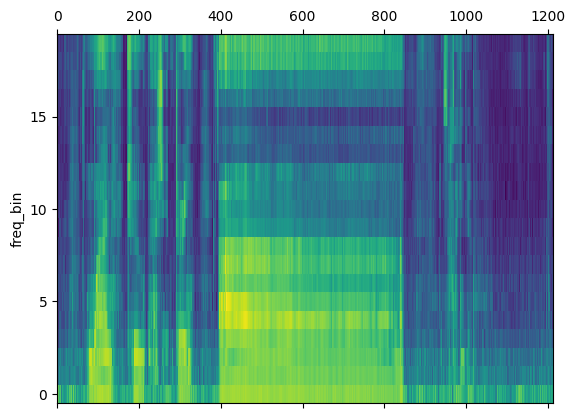

In [2]:
dataset = VBAIDataset('../bids_with_sensitive_recordings')
path = '../bids_with_sensitive_recordings/sub-9c6e4508-5a33-4e3c-9058-b21503c5966e/ses-291F92AC-4B67-4A6E-9AE2-6ACB15772371/audio/sub-9c6e4508-5a33-4e3c-9058-b21503c5966e_ses-291F92AC-4B67-4A6E-9AE2-6ACB15772371_Prolonged-vowel_rec-Prolonged-vowel'
data = torch.load(path + '.pt')
melfilterbank = data["melfilterbank"]
print(data.keys())
mfcc = data["mfcc"]
pt_spec = data["specgram"]
audio = Audio.from_filepath(path + '.wav')
audio = resample_audios([audio], resample_rate=16000)[0]
win_length = 20
hop_length = 10
nfft = None
features_specgram = extract_spectrogram_from_audios([audio],  win_length=win_length, hop_length=hop_length, n_fft=nfft)
features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10))).T
pt_features_specgram = 10.0 * torch.log10(torch.maximum(pt_spec, torch.full(pt_spec.size(), fill_value=1e-10))).T
plot_specgram(features_specgram, audio.sampling_rate)
plot_specgram(mfcc.T, audio.sampling_rate)
plot_specgram(melfilterbank.T, audio.sampling_rate)

### Dataset / diagnosis extraction

In [3]:
# loading the dataset
dataset = VBAIDataset('../bids_with_sensitive_recordings/')

target_diagnosis = 'airway_stenosis' #airway_stenosis voc_fold_paralysis

In [4]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

In [5]:
qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].drop_duplicates(subset='recording_session_id')

person_session_pairs.reset_index(drop=True, inplace=True)

print('Found {} person/session pairs'.format(len(person_session_pairs)))

Found 204 person/session pairs


In [6]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
participant_df = participant_df[['record_id', target_diagnosis]]
participant_df.shape

(178, 2)

In [7]:
Train1 = pd.merge(person_session_pairs, participant_df, on='record_id', how='inner')
Train1.shape

(204, 3)

### Demographics

In [8]:
dg = pd.read_csv('../demographics.csv')
dg = dg[(pd.notna(dg['household_income_usa']) | pd.notna(dg['household_income_ca'])) &
                                   (~((dg['household_income_usa'] == 'Prefer not to answer') | 
                                      (dg['household_income_ca'] == 'Prefer not to answer')))]
pre_train_labeled = pd.DataFrame(dg[["record_id", "demographics_session_id"]])

for index, row in dg.iterrows():
    if pd.notna(dg.loc[index, "household_income_usa"]) and dg.loc[index, "household_count"] >= 3: # USD; HH >= 3
        income = dg.loc[index, "household_income_usa"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
    
    elif pd.notna(dg.loc[index, "household_income_usa"]): # USD; HH < 3
        income = dg.loc[index, "household_income_usa"]
        if income in ['< $15,000']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$15,000 to $29,999', '$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$100,000 to $149,999', '$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
        
    elif pd.notna(dg.loc[index, "household_income_ca"]):  # CA; HH >= 3
        income = dg.loc[index, "household_income_ca"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_ca")
    else:
        print(index)
        
display(len(set(pre_train_labeled[pre_train_labeled["SES"] == 0]['record_id'].to_list())))

14

In [9]:
Train = pd.merge(participant_df, pre_train_labeled, on='record_id', how='left')
columns_to_fill = ['demographics_session_id', 'SES']
Train[columns_to_fill] = Train[columns_to_fill].fillna(-1)
columns_to_check = ["record_id"]
Train = Train.drop_duplicates(subset=columns_to_check, keep='first')
Train.shape

(178, 4)

In [10]:
duplicated_records = Train.groupby('record_id').filter(lambda x: len(x) > 1)
display(duplicated_records[target_diagnosis].value_counts()) #repeated values

Series([], Name: count, dtype: int64)

In [11]:

X = Train[['record_id', 'SES']]
y = Train[['SES', target_diagnosis]]

# combined stratification column
y['stratify_col'] = y['SES'].astype(str) + '_' + y[target_diagnosis].astype(str)

#split the data into train, val, test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.37, stratify=y['stratify_col']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp['stratify_col']
)

# remove the temporary strat column
y_train = y_train.drop(['stratify_col', 'SES'], axis=1)
y_val = y_val.drop(['stratify_col', 'SES'], axis=1)
y_test = y_test.drop(['stratify_col', 'SES'], axis=1)

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train = pd.merge(train, person_session_pairs, on='record_id', how='inner')
val = pd.merge(val, person_session_pairs, on='record_id', how='inner')
test = pd.merge(test, person_session_pairs, on='record_id', how='inner')

# X_train = train[['record_id', 'recording_session_id', 'SES']]
# y_train = train[[target_diagnosis]]

# X_val = val[['record_id', 'recording_session_id', 'SES']]
# y_val = val[[target_diagnosis]]

# X_test = test[['record_id', 'recording_session_id', 'SES']]
# y_test = test[[target_diagnosis]]

# print("train", y_train[target_diagnosis].value_counts())
# print("validation", y_val[target_diagnosis].value_counts())
# print("test", y_test[target_diagnosis].value_counts())

# print("train", X_train['SES'].value_counts())
# print("validation", X_val['SES'].value_counts())
# print("test", X_test['SES'].value_counts())

### Dataset

In [12]:
# rainbow, story recall, Picture description
class MelfilterBankDatasetWithMultisampling(torch.utils.data.Dataset):
	def __init__(self, data, segment_size):
		self.segment_size = segment_size
		self.data = data
		self.data[target_diagnosis] = self.data[target_diagnosis].astype(float)
		self.data.reset_index(drop=True, inplace=True)
		
		# get location for every recording of rainbow passage // generate multiple samples per recording
		index = 0
		while index < len(self.data):
			row = self.data.iloc[index]
			if not pd.notna(row['record_id']):
				self.data = self.data.drop(index = index)
				self.data.reset_index(drop=True, inplace=True)
				# index += 1
				# display("dropped", row)
				continue
			subject = "sub-" + row['record_id']
			session = "ses-" + row['recording_session_id']
			location = str("../bids_with_sensitive_recordings/" + subject + "/" + session + '/audio/'+subject+"_"+session+"_Prolonged-vowel_rec-Prolonged-vowel")
			if os.path.exists(location + '.wav'):
				self.data.at[index, "location"] = location
				self.data.at[index, "segment"] = 0
                audio = Audio.from_filepath(location + ".wav")
                audio = resample_audios(audio, resample_rate=16000)[0]
                audio.waveform = audio.waveform.squeeze()
				num_segments = audio.waveform.shape[-1] // 160 // self.segment_size #audio size mapping to spectrogram size
    			#insert num_segment rows with different segment number(each record is different timeframe of the same recording)
				count = 1
				while count < num_segments:
					row_to_copy = self.data.iloc[index]
					row_df = pd.DataFrame([row_to_copy])
					self.data = pd.concat([self.data.iloc[:index+1], row_df, self.data.iloc[index+1:]]).reset_index(drop=True)
					index += 1
					self.data.at[index, "segment"] = count
					count += 1

			else:
				# print all patients without Rainbow passage recording   
				# print("Location does not exist ", location)
				data.at[index, "location"] = "DNE"
				self.data = self.data.drop(index = index)
				self.data.reset_index(drop=True, inplace=True)
				index-=1
			index += 1
		self.data.reset_index(drop=True, inplace=True)

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		if not os.path.exists(self.data.loc[idx, "location"]+'.pt'):
			display("error", self.data.loc[idx, "location"])
		torch_data = torch.load(self.data.loc[idx, "location"]+'.pt')
		melfilterbank = torch_data["melfilterbank"]
		if melfilterbank.shape[0] >= self.segment_size:
			seg_num = self.data.loc[idx, "segment"]
			max_seg_size = melfilterbank.size(0) // self.segment_size
	
			start = (melfilterbank.size(0) - self.segment_size * max_seg_size) // 2
			start = int(start + self.segment_size * seg_num)

			melfilterbank = melfilterbank[start:start+self.segment_size, :]
		else:
			rows_to_add = max(0, self.segment_size - melfilterbank.shape[0])
			melfilterbank = torch.nn.functional.pad(melfilterbank, (0, 0, 0, rows_to_add), mode='constant', value=0)

		label = self.data.loc[idx, target_diagnosis]
  
		ses = self.data.loc[idx, 'SES']
		
		return {'signal': melfilterbank.T, 'label': label, 'SES': ses}

In [13]:
# train_df = pd.concat([X_train, y_train], axis=1)
# val_df = pd.concat([X_val, y_val], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)

train_dataset = MelfilterBankDatasetWithMultisampling(train, 170)
val_dataset = MelfilterBankDatasetWithMultisampling(val, 170)
test_dataset = MelfilterBankDatasetWithMultisampling(test, 170)

print("Train dataset counts: ")
print(train_dataset.data[["SES", target_diagnosis]].value_counts().sort_index())
print("\nValidation dataset counts: ")
print(val_dataset.data[["SES", target_diagnosis]].value_counts().sort_index())
print("\nTest dataset counts: ")
print(test_dataset.data[["SES", target_diagnosis]].value_counts().sort_index())

print("Perform data check:")
check_loc_1 = train_dataset.data[~train_dataset.data['location'].str.endswith('_Prolonged-vowel_rec-Prolonged-vowel')].empty
check_loc_2 = val_dataset.data[~val_dataset.data['location'].str.endswith('_Prolonged-vowel_rec-Prolonged-vowel')].empty
check_loc_3 = test_dataset.data[~test_dataset.data['location'].str.endswith('_Prolonged-vowel_rec-Prolonged-vowel')].empty
if ~check_loc_1 and ~check_loc_2 and ~check_loc_3:
    print("\tAll locations are not NaN")
else:
    print("\tFound incorrect locations")
    
check_dublicates_1 = train_dataset.data[train_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
check_dublicates_2 = val_dataset.data[val_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
check_dublicates_3 = test_dataset.data[test_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
if ~check_loc_1 and ~check_loc_2 and ~check_loc_3:
    print("\tNo dublicates were generated")
else:
    print("\tCheck dublicated values!")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=18, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=6, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=6, shuffle=False)

for batch in val_dataloader:
    print(batch['signal'].shape)
    break

Train dataset counts: 
SES   airway_stenosis
-1.0  0.0                188
      1.0                 86
 0.0  0.0                 42
      1.0                 11
 1.0  0.0                124
      1.0                 33
 2.0  0.0                 91
      1.0                 63
 3.0  0.0                 79
      1.0                 43
Name: count, dtype: int64

Validation dataset counts: 
SES   airway_stenosis
-1.0  0.0                52
      1.0                28
 0.0  0.0                14
      1.0                 7
 1.0  0.0                31
      1.0                 7
 2.0  0.0                28
      1.0                17
 3.0  0.0                21
      1.0                13
Name: count, dtype: int64

Test dataset counts: 
SES   airway_stenosis
-1.0  0.0                49
      1.0                25
 0.0  0.0                11
      1.0                 7
 1.0  0.0                28
      1.0                11
 2.0  0.0                25
      1.0                21
 3.0  0.0    

### Graphs for Dataset

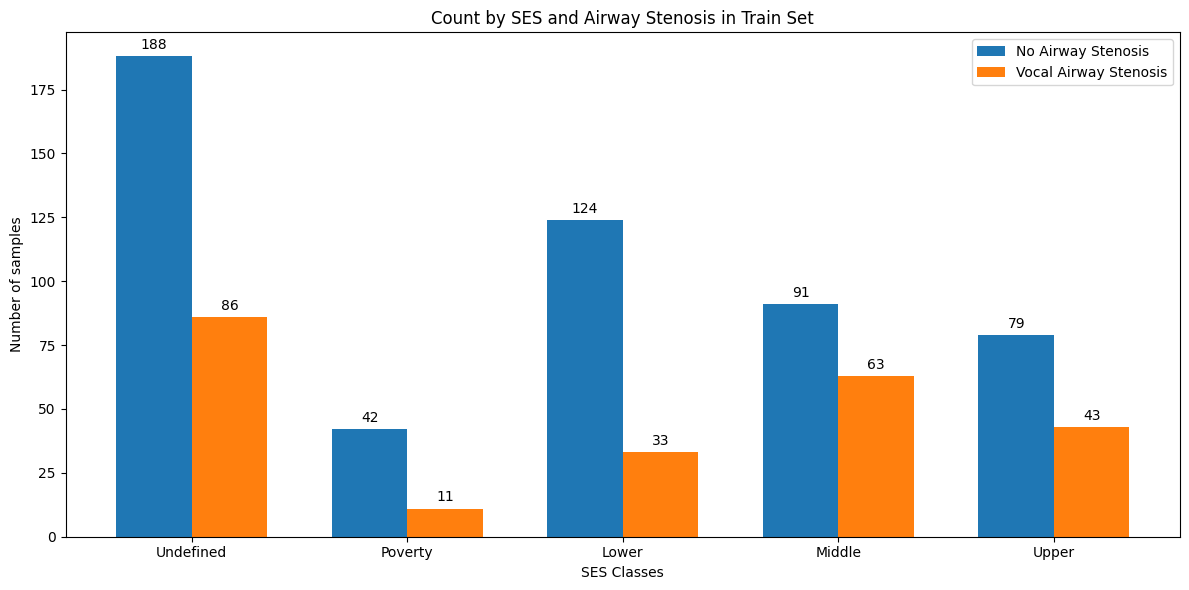

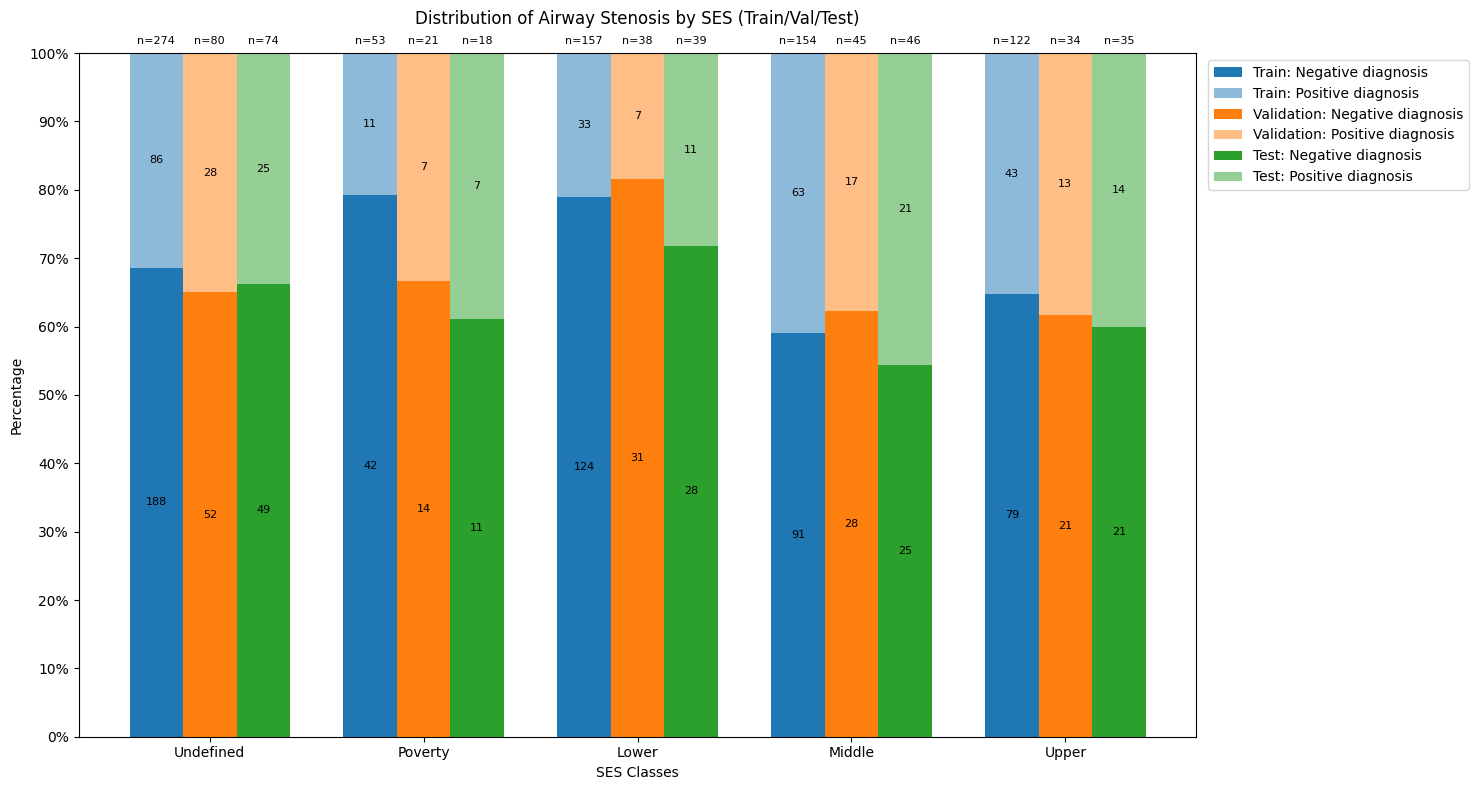

In [14]:
# Data
tr = train_dataset.data[["SES", target_diagnosis]].value_counts().sort_index()
v = val_dataset.data[["SES", target_diagnosis]].value_counts().sort_index()
t = test_dataset.data[["SES", target_diagnosis]].value_counts().sort_index()
ses = ["Undefined", "Poverty", "Lower", "Middle", "Upper"]
vfp_0 = [tr[-1][0], tr[0][0], tr[1][0], tr[2][0], tr[3][0]]
vfp_1 = [tr[-1][1], tr[0][1], tr[1][1], tr[2][1], tr[3][1]]

# Set up the bar chart
x = np.arange(len(ses))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Create the bars
rects1 = ax.bar(x - width/2, vfp_0, width, label='No Airway Stenosis')
rects2 = ax.bar(x + width/2, vfp_1, width, label='Vocal Airway Stenosis')

# Customize the chart
ax.set_ylabel('Number of samples')
ax.set_xlabel('SES Classes')
ax.set_title('Count by SES and Airway Stenosis in Train Set')
ax.set_xticks(x)
ax.set_xticklabels(ses)
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
        xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# Three configurations for each SES class
vfp_0 = [
    [tr[-1][0], tr[0][0], tr[1][0], tr[2][0], tr[3][0]],  # Configuration 1
    [v[-1][0], v[0][0], v[1][0], v[2][0], v[3][0]],  # Configuration 2
    [t[-1][0], t[0][0], t[1][0], t[2][0], t[3][0]]  # Configuration 3
]
vfp_1 = [
    [tr[-1][1], tr[0][1], tr[1][1], tr[2][1], tr[3][1]],  # Configuration 1
    [v[-1][1], v[0][1], v[1][1], v[2][1], v[3][1]],  # Configuration 2
    [t[-1][1], t[0][1], t[1][1], t[2][1], t[3][1]]    # Configuration 3
]

# Calculate totals and percentages for each configuration
totals = [[a + b for a, b in zip(vfp_0[i], vfp_1[i])] for i in range(3)]
perc_0 = [[a / total * 100 for a, total in zip(vfp_0[i], totals[i])] for i in range(3)]
perc_1 = [[b / total * 100 for b, total in zip(vfp_1[i], totals[i])] for i in range(3)]

# Set up the bar chart
fig, ax = plt.subplots(figsize=(15, 8))

# Set the width of each bar and the positions of the bars
width = 0.25
x = np.arange(len(ses))

# Create the stacked bars for each configuration
config = ["Train", "Validation", "Test"]
for i in range(3):
    ax.bar(x + (i-1)*width, perc_0[i], width, label=f'{config[i]}: Negative diagnosis', color=f'C{i}')
    ax.bar(x + (i-1)*width, perc_1[i], width, bottom=perc_0[i], label=f'{config[i]}: Positive diagnosis', color=f'C{i}', alpha=0.5)

# Customize the chart
ax.set_ylabel('Percentage')
ax.set_xlabel('SES Classes')
ax.set_title('Distribution of Airway Stenosis by SES (Train/Val/Test)\n')
ax.set_xticks(x)
ax.set_xticklabels(ses)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

# Set y-axis to show percentages
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 10)])

# Add sample count labels on the bars
for i in range(3):
    for j, (v0, v1, p0, p1) in enumerate(zip(vfp_0[i], vfp_1[i], perc_0[i], perc_1[i])):
        ax.text(x[j] + (i-1)*width, p0/2, str(v0), ha='center', va='center', fontsize=8)
        ax.text(x[j] + (i-1)*width, p0 + p1/2, str(v1), ha='center', va='center', fontsize=8)

# Add total sample count above each bar
for i in range(3):
    for j, total in enumerate(totals[i]):
        ax.text(x[j] + (i-1)*width, 101, f'n={total}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [109]:
train_class0_count = train_dataset.data[target_diagnosis].value_counts()[0]
train_class1_count = train_dataset.data[target_diagnosis].value_counts()[1]
class_counts = [train_class0_count, train_class1_count]
total_samples = sum(class_counts)
class_weights = [total_samples / (2 * count) for count in class_counts]
weights = torch.tensor(class_weights, dtype=torch.float32)
print(weights[0])
print(weights[1])
pos_weight = weights[1]/ weights[0]

tensor(0.7367)
tensor(1.5560)


### CNN Model

In [150]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Conv1d(20, 48, kernel_size=9, stride=3, padding=2)
        self.bn1 = nn.BatchNorm1d(48)
        self.mp = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Calculate the input size to the first linear layer
        self.fc_input_size = self._calculate_fc_input_size()
  
        self.fc1 = nn.Linear(self.fc_input_size, 64)
        self.fc3 = nn.Linear(64, 1)  # One output neuron for binary classification

    def forward(self, x):
        x = self.mp(self.bn1(torch.nn.functional.relu(self.conv1(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(x)  # Apply dropout before the linear layers
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc3(x)  # sigmoid applied in BCEWithLogitsLoss
        return x

    def _calculate_fc_input_size(self):
        x = torch.randn(1, 20, 170)
        x = self.mp(self.bn1(torch.nn.functional.relu(self.conv1(x))))
        return x.view(x.size(0), -1).size(1)

In [151]:
cnn = CNN_1D()
_ = summary(cnn, (20, 170))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 48, 56]           8,688
       BatchNorm1d-2               [-1, 48, 56]              96
         MaxPool1d-3               [-1, 48, 28]               0
           Dropout-4                 [-1, 1344]               0
            Linear-5                   [-1, 64]          86,080
            Linear-6                    [-1, 1]              65
Total params: 94,929
Trainable params: 94,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.36
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


In [152]:
def eval(model, dataloader, criterion):
    model.eval()
    acc = 0
    total = 0
    val_losses = []
    
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    all_predictions = []
    all_ground_truths = []
    for batch in dataloader:
        with torch.no_grad():
            outputs = model(batch['signal']).squeeze()
            loss = criterion(outputs, batch['label'])
            val_losses.append(loss.item())
            
            predicted = (torch.sigmoid(outputs) >= threshold).float()
            ground_truth = batch['label']
            acc += (predicted == ground_truth).sum().item()
            total += ground_truth.size(0)
            
            true_positives += ((predicted == 1) & (ground_truth == 1)).sum().item()
            true_negatives += ((predicted == 0) & (ground_truth == 0)).sum().item()
            false_positives += ((predicted == 1) & (ground_truth == 0)).sum().item()
            false_negatives += ((predicted == 0) & (ground_truth == 1)).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_ground_truths.extend(ground_truth.cpu().numpy().flatten())

    accuracy = (true_positives + true_negatives) / len(all_predictions)
    val_loss = sum(val_losses) / len(val_losses)
    return accuracy, val_loss, all_predictions, all_ground_truths

cnn = CNN_1D()
threshold = 0.5
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

num_epochs = 15
best_val_acc = 0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    cnn.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = cnn(batch['signal']).squeeze(1)
        loss = criterion(outputs, batch['label'])
        train_loss += loss.item() * len(batch['signal'])
        loss.backward()
        optimizer.step()
    scheduler.step()
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    val_acc, val_loss, _, _ = eval(cnn, val_dataloader, criterion)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn.state_dict(), '../../models/Vowel_airway_stenosis_1d_cnn_model.pt')
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/15, Train Loss: 0.9609, Val Loss: 0.9624, Val Acc: 0.6266
Epoch 2/15, Train Loss: 0.9014, Val Loss: 0.9247, Val Acc: 0.6052
Epoch 3/15, Train Loss: 0.8876, Val Loss: 0.9436, Val Acc: 0.5923
Epoch 4/15, Train Loss: 0.8438, Val Loss: 0.9350, Val Acc: 0.5880
Epoch 5/15, Train Loss: 0.7895, Val Loss: 0.9981, Val Acc: 0.6695
Epoch 6/15, Train Loss: 0.7839, Val Loss: 0.9603, Val Acc: 0.6395
Epoch 7/15, Train Loss: 0.7640, Val Loss: 0.9471, Val Acc: 0.6481
Epoch 8/15, Train Loss: 0.7746, Val Loss: 0.9479, Val Acc: 0.6567
Epoch 9/15, Train Loss: 0.7557, Val Loss: 0.9522, Val Acc: 0.6567
Epoch 10/15, Train Loss: 0.7572, Val Loss: 0.9207, Val Acc: 0.6352
Epoch 11/15, Train Loss: 0.7448, Val Loss: 0.9372, Val Acc: 0.6438
Epoch 12/15, Train Loss: 0.7550, Val Loss: 0.9207, Val Acc: 0.6309
Epoch 13/15, Train Loss: 0.7526, Val Loss: 0.9260, Val Acc: 0.6567
Epoch 14/15, Train Loss: 0.7485, Val Loss: 0.9282, Val Acc: 0.6567
Epoch 15/15, Train Loss: 0.7582, Val Loss: 0.9415, Val Acc: 0.6481


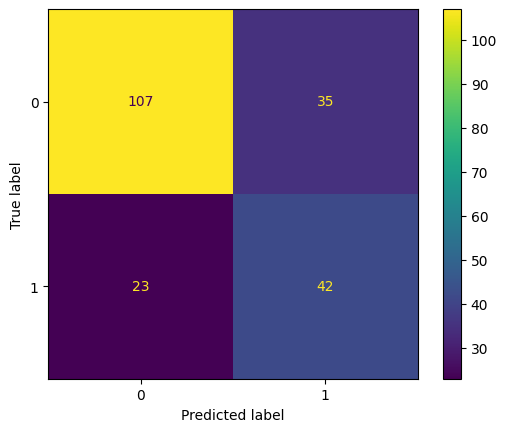

              precision    recall  f1-score   support

     Class 0       0.82      0.75      0.79       142
     Class 1       0.55      0.65      0.59        65

    accuracy                           0.72       207
   macro avg       0.68      0.70      0.69       207
weighted avg       0.74      0.72      0.73       207



In [162]:
_, _, predictions, ground_truths = eval(cnn, test_dataloader, criterion)
cm = confusion_matrix(ground_truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
report = classification_report(ground_truths, predictions, target_names=['Class 0', 'Class 1'])
print(report)

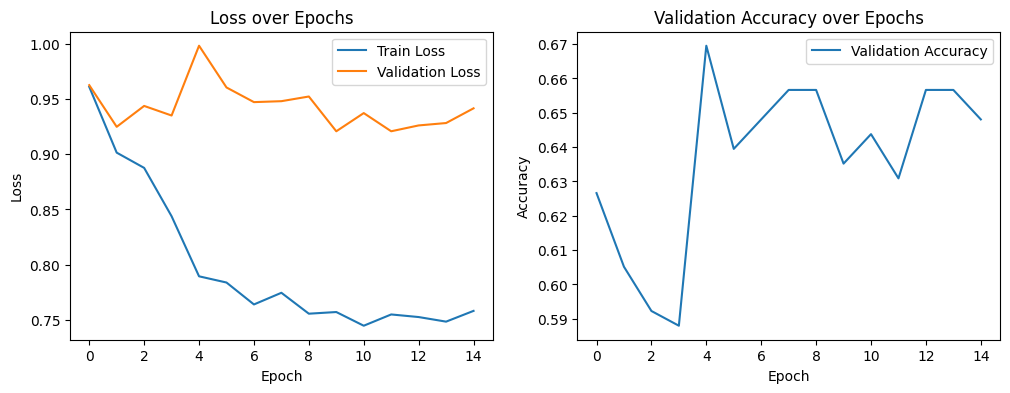

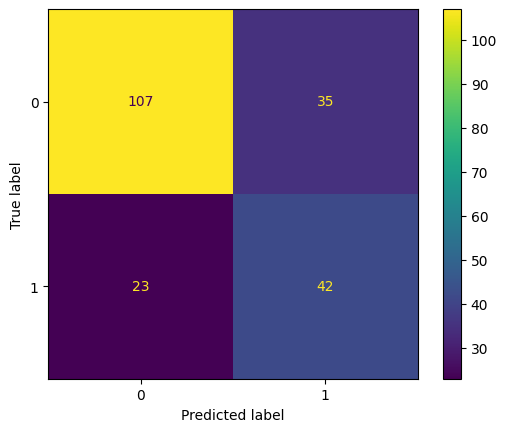

              precision    recall  f1-score   support

     Class 0       0.82      0.75      0.79       142
     Class 1       0.55      0.65      0.59        65

    accuracy                           0.72       207
   macro avg       0.68      0.70      0.69       207
weighted avg       0.74      0.72      0.73       207



In [163]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy over Epochs')
plt.show()

cnn2 = CNN_1D()
# Confusion matrix
# cnn2.load_state_dict(torch.load('../../models/Vowel_airway_stenosis_1d_cnn_model.pt'))
# _, _, predictions, ground_truths = eval(cnn2, test_dataloader, criterion)

cm = confusion_matrix(ground_truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
report = classification_report(ground_truths, predictions, target_names=['Class 0', 'Class 1'])
print(report)

In [164]:
def analyze_test_predictions(model, test_dataloader):
    model.eval()
    all_test_values = []
    all_predictions = []
    all_ses = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            inputs = batch['signal']
            labels = batch['label']
            ses = batch['SES']
            
            outputs = torch.sigmoid(model(inputs)).squeeze()
            predicted = (outputs >= threshold).float()
            
            all_test_values.extend(labels.cpu().numpy().flatten())
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_ses.extend(ses.cpu().numpy())
    
    # Create DataFrame
    df = pd.DataFrame({
        'Ses': all_ses,
        'test_value': all_test_values,
        'model_prediction': all_predictions
    })
    
    return df

df = analyze_test_predictions(cnn, test_dataloader)

In [165]:
df_undef = df[df['Ses'] == -1]
df_poverty = df[df['Ses'] == 0]
df_lower = df[df['Ses'] == 1]
df_middle = df[df['Ses'] == 2]
df_upper = df[df['Ses'] == 3]

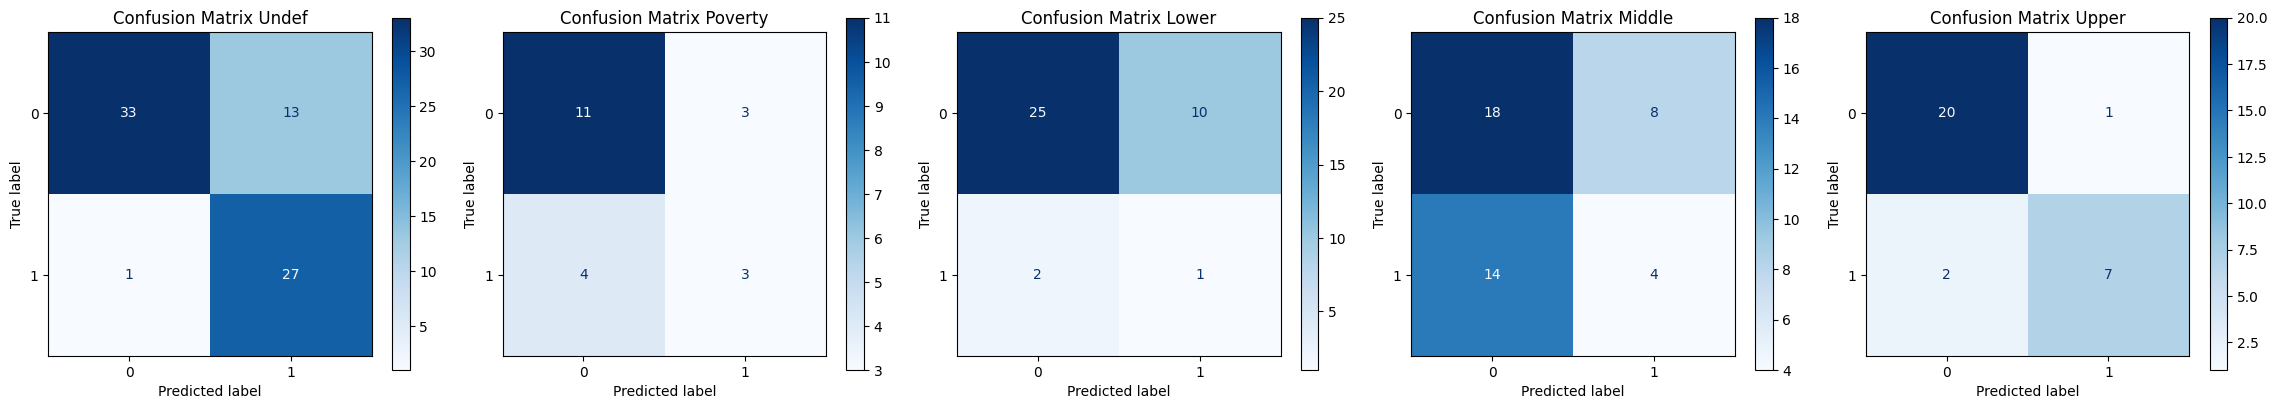

In [166]:
dataframes = [df_undef, df_poverty, df_lower, df_middle, df_upper]
titles = [
    'Confusion Matrix Undef',
    'Confusion Matrix Poverty',
    'Confusion Matrix Lower',
    'Confusion Matrix Middle',
    'Confusion Matrix Upper'
]

# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(23, 4))

# Keep track of the index for the subplot
index = 0

for frame, title in zip(dataframes, titles):
    if not df.empty:  # Check if the dataframe is not empty
        cm = confusion_matrix(frame['test_value'], frame['model_prediction'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax[index], cmap='Blues')
        ax[index].title.set_text(title)
        index += 1

# Hide any remaining subplots
for i in range(index, len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

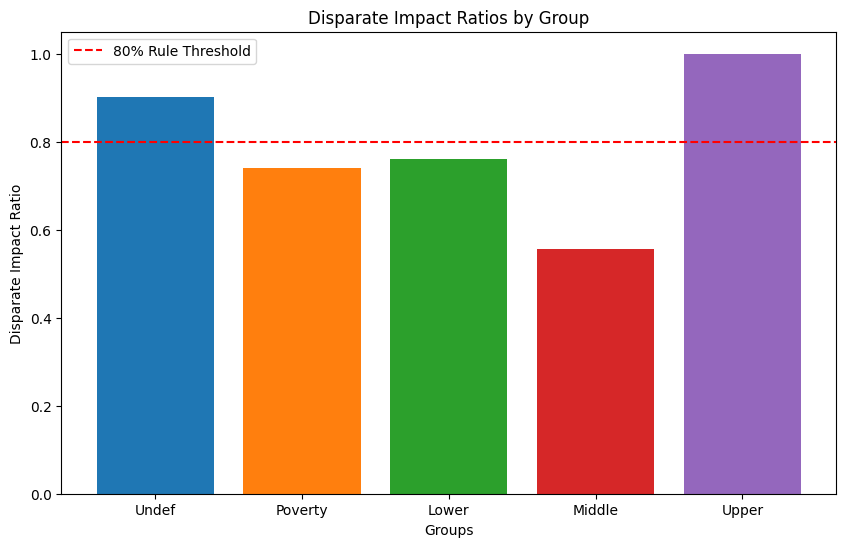

---SES---
Chi-Square Statistic: 14.056125992756208, p-value: 0.007118062450059838
Disparate Impact Ratio for Group Undef: 0.9009009009009009
Disparate Impact Ratio for Group Poverty: 0.7407407407407407
Disparate Impact Ratio for Group Lower: 0.7602339181286549
Disparate Impact Ratio for Group Middle: 0.5555555555555556
Disparate Impact Ratio for Group Upper: 1.0



In [167]:
def chi_DIR_plot(demographics, ground_truth, _predictions_, attribute='SES', calc_chi_square=True):
    
    #print("---" , attribute.upper(), "---")
    
    sensitive_attribute = demographics
        
    contingency_table = pd.crosstab(sensitive_attribute, _predictions_, rownames=[attribute], colnames=['Prediction'])
    
    # Compare distributions
    _print_string_ = f'---{attribute.upper()}---\n'
    if calc_chi_square:
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        chi_square_result = {
            "chi2_stat": chi2_stat,
            "p_value": p_value,
            "dof": dof,
            "expected": expected
        }
        #print(f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}')
        _print_string_ += f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}\n'

    unique_groups = [-1.0, 0.0, 1.0, 2.0, 3.0]
    favorable_outcome = {}

    map_func = {
        '-1.0' : 'Undef',
        '0.0' : 'Poverty',
        '1.0' : 'Lower',
        '2.0' : 'Middle',
        '3.0' : 'Upper',
    }
        
    accuracies = [_predictions_ == ground_truth]
    for group in unique_groups:
        #group_predictions = _predictions_[sensitive_attribute == group]
        group_predictions = accuracies[0][sensitive_attribute == group]
        
        favorable_outcome[group] = np.mean(group_predictions)
        
    most_favorable_group = max(favorable_outcome, key=favorable_outcome.get)
    disparate_impact_ratios = {group: favorable_outcome[group] / favorable_outcome[most_favorable_group] for group in unique_groups}
    
    #Print the disparate impact ratios
    for group, ratio in disparate_impact_ratios.items():
        _print_string_ += f'Disparate Impact Ratio for Group {map_func[str(group)]}: {ratio}\n'
        #print(f'Disparate Impact Ratio for Group {map_func(group)}: {ratio}')

    # Plotting the disparate impact ratios
    plt.figure(figsize=(10, 6))
    groups = [map_func[str(group)] for group in unique_groups]
    ratios = [disparate_impact_ratios[group] for group in unique_groups]
    plt.bar(groups, ratios, color=plt.get_cmap('tab10').colors[:len(unique_groups)])
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Rule Threshold')
    plt.xlabel('Groups')
    plt.ylabel('Disparate Impact Ratio')
    plt.title('Disparate Impact Ratios by Group')
    plt.legend()
    plt.show()

    return chi_square_result, disparate_impact_ratios, _print_string_

_, _, print_str = chi_DIR_plot(df['Ses'], df['test_value'], df['model_prediction'])
print(print_str)
